In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
sns.set()
%matplotlib inline
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')

In [4]:
news = pd.read_csv('./Dataset/News_Final.csv')
fe = pd.read_csv('./Dataset/Facebook_Economy.csv')

In [5]:
news.columns

Index(['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate',
       'SentimentTitle', 'SentimentHeadline', 'Facebook', 'GooglePlus',
       'LinkedIn'],
      dtype='object')

In [6]:
news.head(3)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1


### Problem1 : Is there any difference among the three platforms?
1. Check the variance: Before we dig into the distributions of the variables, let's first make sure that the popularity varies Facebook/LinkedIn/GooglePlus.  <font color='red'>--- TASK: Diff plot/QQ plot</font> (Consider differece level: news/source/topic)
2. Pick those news with huge difference, check what happened to those news.  <font color='red'>--- TASK: Pick the news with largest variance, check their sources, times, etc. Conclude what happened on these news. </font>
3. Check the variables: group by time; sources; sentiment; etc. 
4. Check the time series: <font color='red'>--- TASK: select difference time slice, and draw QQ plot. </font>

### Problem2 : Can we predict the popularity using the given variables? 
1. Theory: Time Series prediction: How do people predict popularity?     <font color='red'>--- TASK: read papers and blogs</font>
2. Check the variance inside each topic group: for example, if we use economy as dataset. Is there any relationship between the content/sentiment and their popularity? 

### Data Sanity Check: How many data can we actually use


1. Removed the news published on less than 3 platforms.

2. Checked the news with 0 popularity. Why? We need to calculate difference among platforms, if there are lots of news with 0 popularity, then the difference might not be real. -- Side Note: sources influence popularity. If it is completely the sources that influence the popularity rather than the platform, then we need to remove these items before intepreting the pop diff results. But we need to take sources back into consideration when building prediction model. 

#### How many news are on all three platforms?  Two platforms?  


In [7]:
print(f'Total news:{len(news)}\n')
F = news[news['Facebook']>0].Facebook
L = news[news['LinkedIn']>0].LinkedIn
G = news[news['GooglePlus']>0].GooglePlus
print(f'News on Facebook: {len(F)}')
print(f'News on LinkedIn: {len(L)}')
print(f'News on GooglePlus: {len(G)}\n')

news['num_platform'] = news["Facebook"].map(str) + ',' + news["GooglePlus"].map(str)+  ',' + news['LinkedIn'].map(str)
news['num_platform'] = news['num_platform'].apply(lambda x: [int(num) for num in x.split(',')])
news['num_platforms'] = news['num_platform'].apply(lambda x: 3 - x.count(-1)-x.count(0))
print(pd.DataFrame(news['num_platforms'].value_counts()).sort_index(ascending = False))

print('\nLet\'s drop the news with 0/1/2 platform!')

Total news:93239

News on Facebook: 64793
News on LinkedIn: 37640
News on GooglePlus: 36940

   num_platforms
3          23328
2          22608
1          24173
0          23130

Let's drop the news with 0/1/2 platform!


In [40]:
news_df = news[news['num_platforms']==3]

### How many news in each category?

In [41]:
len(news_df)
news_df.Topic.value_counts()

obama        8419
economy      7089
microsoft    7084
palestine     736
Name: Topic, dtype: int64

### How's the news popularity distributed on each platform? 

In [42]:
news_df['Facebook'].describe()

count    23328.000000
mean       327.159251
std       1051.884191
min          1.000000
25%         14.000000
50%         48.000000
75%        196.000000
max      40836.000000
Name: Facebook, dtype: float64

In [43]:
news_df['LinkedIn'].describe()

count    23328.000000
mean        45.899220
std        140.136478
min          1.000000
25%          2.000000
50%          9.000000
75%         32.000000
max       6362.000000
Name: LinkedIn, dtype: float64

In [44]:
news_df['GooglePlus'].describe()

count    23328.000000
mean        12.370499
std         33.260907
min          1.000000
25%          2.000000
50%          4.000000
75%         10.000000
max       1267.000000
Name: GooglePlus, dtype: float64

### Let's normalize the popularity
Since the user base vary among the three platforms, we need to normalize the popularities. 

In [45]:
scaler = StandardScaler()
news_df['Facebook_scaled'] = scaler.fit_transform(news_df['Facebook'].values.reshape(-1, 1))
news_df['GooglePlus_scaled'] = scaler.fit_transform(news_df['GooglePlus'].values.reshape(-1, 1))
news_df['LinkedIn_scaled'] = scaler.fit_transform(news_df['LinkedIn'].values.reshape(-1, 1))

Text(0, 0.5, '# News')

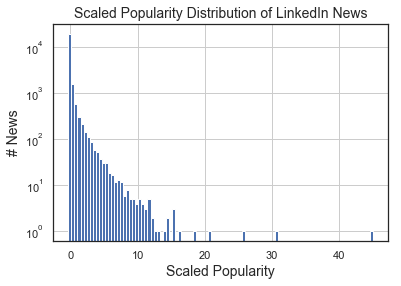

In [46]:
news_df['LinkedIn_scaled'].hist(bins=100)
plt.yscale('log')
plt.title('Scaled Popularity Distribution of LinkedIn News', fontsize= 14)
plt.xlabel('Scaled Popularity',fontsize= 14)
plt.ylabel('# News',fontsize= 14)

In [47]:
news_df['num_platform_scaled'] = news_df["Facebook_scaled"].map(str) + ',' + news_df["GooglePlus_scaled"].map(str)+  ',' + news_df['LinkedIn_scaled'].map(str)
news_df['num_platform_scaled'] = news_df['num_platform_scaled'].apply(lambda x: [float(num) for num in x.split(',')])

### Is there any variance of same news on three platforms?  If there is, by how much?
1. Max - Min 
2. QQ plot

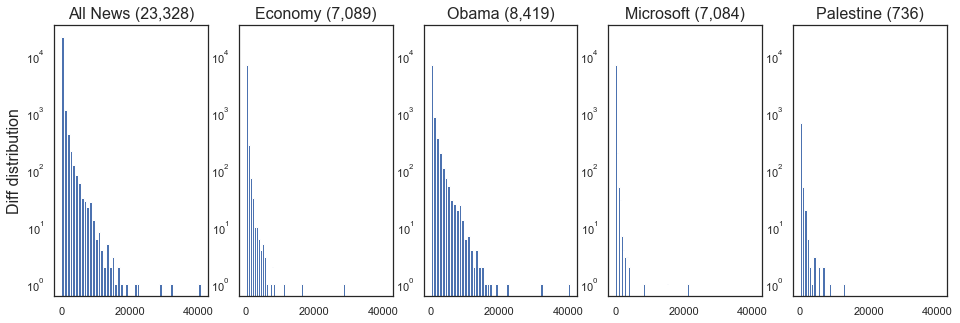

In [38]:
news_df['diff_among_groups'] = news_df['num_platform'].apply(lambda x: max(x)-min(x))
diff_among_groups = news_df['num_platform'].apply(lambda x: max(x)-min(x))
diff_econ = news_df[news_df['Topic']=='economy']['num_platform'].apply(lambda x: max(x)-min(x))
diff_obama = news_df[news_df['Topic']=='obama']['num_platform'].apply(lambda x: max(x)-min(x))
diff_micro = news_df[news_df['Topic']=='microsoft']['num_platform'].apply(lambda x: max(x)-min(x))
diff_pale = news_df[news_df['Topic']=='palestine']['num_platform'].apply(lambda x: max(x)-min(x))


plt.figure(figsize = (16,5))
ax1 = plt.subplot(1,5,1)
plt.hist(diff_among_groups,bins =50)
plt.yscale('log')
plt.ylabel('Diff distribution', fontsize = 16)
plt.title('All News (23,328)', fontsize = 16)

ax2 = plt.subplot(1,5,2,sharey = ax1, sharex = ax1)
plt.hist(diff_econ,bins =50)
plt.yscale('log')
plt.title('Economy (7,089)', fontsize = 16)

ax5 = plt.subplot(1,5,3, sharey = ax1, sharex = ax1)
plt.hist(diff_obama,bins =50)
plt.yscale('log')
plt.title('Obama (8,419)', fontsize = 16);

ax3 = plt.subplot(1,5,4, sharey = ax1,sharex = ax1)
plt.hist(diff_micro,bins =50)
plt.yscale('log')
plt.title('Microsoft (7,084)', fontsize = 16)

ax4 = plt.subplot(1,5,5, sharey = ax1,sharex = ax1)
plt.hist(diff_pale,bins =20)
plt.yscale('log')
plt.title('Palestine (736)', fontsize = 16);

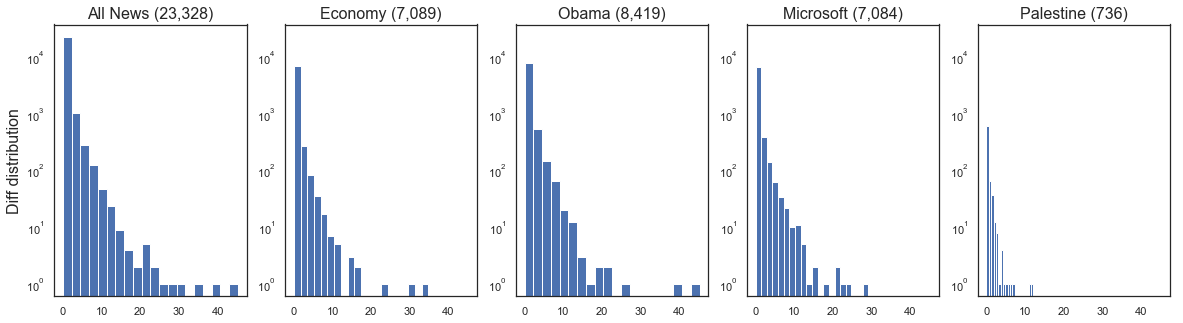

In [50]:
news_df['diff_among_groups'] = news_df['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_among_groups = news_df['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_econ = news_df[news_df['Topic']=='economy']['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_obama = news_df[news_df['Topic']=='obama']['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_micro = news_df[news_df['Topic']=='microsoft']['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_pale = news_df[news_df['Topic']=='palestine']['num_platform_scaled'].apply(lambda x: max(x)-min(x))


plt.figure(figsize = (20,5))
ax1 = plt.subplot(1,5,1)
plt.hist(diff_among_groups,bins =20)
plt.yscale('log')
plt.ylabel('Diff distribution', fontsize = 16)
plt.title('All News (23,328)', fontsize = 16)

ax2 = plt.subplot(1,5,2,sharex = ax1, sharey = ax1)
plt.hist(diff_econ,bins =20)
plt.yscale('log')
plt.title('Economy (7,089)', fontsize = 16)

ax5 = plt.subplot(1,5,3, sharex = ax1,sharey = ax1)
plt.hist(diff_obama,bins =20)
plt.yscale('log')
plt.title('Obama (8,419)', fontsize = 16);

ax3 = plt.subplot(1,5,4, sharex = ax1,sharey = ax1)
plt.hist(diff_micro,bins =20)
plt.yscale('log')
plt.title('Microsoft (7,084)', fontsize = 16)

ax4 = plt.subplot(1,5,5, sharex = ax1, sharey = ax1)
plt.hist(diff_pale,bins =20)
plt.yscale('log')
plt.title('Palestine (736)', fontsize = 16);

Text(0, 0.5, 'Log(scaled_popularity)')

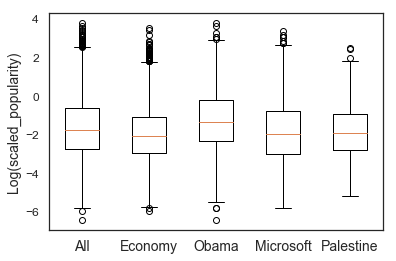

In [51]:
all_log = np.log(diff_among_groups)
eco_log = np.log(diff_econ)
obama_log = np.log(diff_obama)
micro_log = np.log(diff_micro)
pale_log = np.log(diff_pale)

plt.boxplot([all_log, eco_log, obama_log,micro_log,pale_log]);
plt.xticks([1,2,3,4,5],['All', 'Economy', 'Obama','Microsoft','Palestine'], fontsize = 14);
plt.yticks(fontsize = 12)
plt.ylabel('Log(scaled_popularity)',fontsize = 14)

Text(0.5, 1.0, 'Reuters(509)')

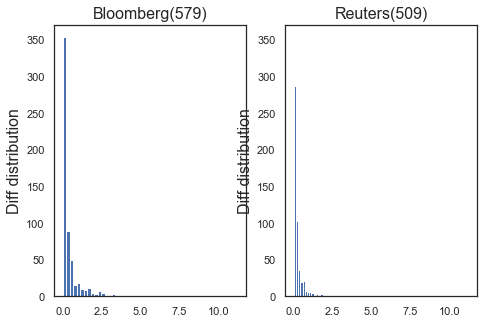

In [52]:
bloom_news = news_df[news_df['Source']=='Bloomberg']
reuter_new = news_df[news_df['Source']=='Reuters']

plt.figure(figsize = (20,5))
ax1 = plt.subplot(1,5,1)
plt.hist(bloom_news.diff_among_groups,bins =50)
#plt.yscale('log')
plt.ylabel('Diff distribution', fontsize = 16)
plt.title('Bloomberg(579)', fontsize = 16)

ax2 = plt.subplot(1,5,2, sharex = ax1, sharey = ax1)
plt.hist(reuter_new.diff_among_groups,bins =50)
#plt.yscale('log')
plt.ylabel('Diff distribution', fontsize = 16)
plt.title('Reuters(509)', fontsize = 16)

Text(0, 0.5, '# News')

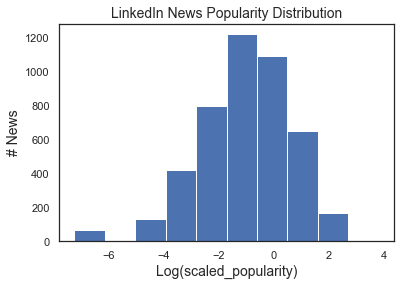

In [54]:
#bloom_box_cox = np.log(bloom_news.diff_among_groups.values)

bloom_box_cox = np.log(news_df['LinkedIn_scaled'])
plt.hist(bloom_box_cox)
plt.title('LinkedIn News Popularity Distribution', fontsize = 14)
plt.xlabel('Log(scaled_popularity)', fontsize = 14)
plt.ylabel('# News',fontsize =14)

#reuter_box_cox = np.log(reuter_new.diff_among_groups)
#plt.hist(reuter_box_cox)

In [55]:
pp_b = sm.ProbPlot(bloom_box_cox)
pp_r = sm.ProbPlot(reuter_box_cox)


fig1 = pp_b.qqplot(line='45')

NameError: name 'sm' is not defined

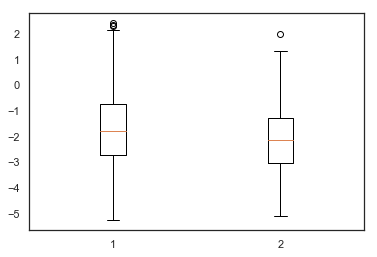

In [94]:
plt.boxplot([bloom_box_cox,reuter_box_cox]);

In [43]:
reuter_new.diff_among_groups.sort_values(ascending = False)

78137    7.145445
76513    3.673322
19280    3.279132
44861    3.076886
37098    2.466425
           ...   
55157    0.010282
37868    0.009844
14304    0.008380
82129    0.007943
59111    0.006041
Name: diff_among_groups, Length: 509, dtype: float64

In [438]:
bloom_pop

748      0.000735
861      0.002669
991      0.000245
1008     0.000294
1023     0.003820
           ...   
88703    0.003110
89832    0.000735
90013    0.001102
91153    0.005118
92640    0.000147
Name: Facebook_scaled, Length: 597, dtype: float64

### Aggragated topics

In [519]:
f_pop = news_df['Facebook_scaled']
l_pop = news_df['LinkedIn_scaled']
g_pop = news_df['GooglePlus_scaled']
'''
f_pop = news_df['Facebook']
l_pop = news_df['LinkedIn']
g_pop = news_df['GooglePlus']
'''

"\nf_pop = news_df['Facebook']\nl_pop = news_df['LinkedIn']\ng_pop = news_df['GooglePlus']\n"

In [56]:
pp_f = sm.ProbPlot(f_pop, fit=False)
pp_l = sm.ProbPlot(l_pop, fit=False)
pp_g = sm.ProbPlot(g_pop, fit=False)

fig1 = pp_f.qqplot(other=pp_l, line='45')
plt.xlabel('LinkedIn')
plt.ylabel('Facebook')

fig2 = pp_g.qqplot(other=pp_l, line='45')
plt.xlabel('LinkedIn')
plt.ylabel('GooglePlus')

fig3 = pp_g.qqplot(other=pp_f, line='45')
plt.xlabel('Facebook')
plt.ylabel('GooglePlus');

AttributeError: module 'scipy.stats' has no attribute 'ProbPlot'

#### We need to filter out those news with higher popularity and see what happens. 

Text(0, 0.5, 'GooglePlus')

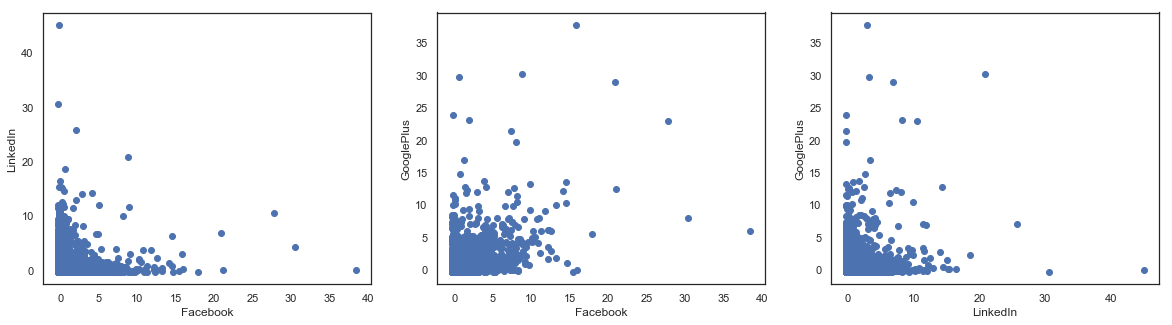

In [529]:
plt.figure(figsize = (20,5))

ax1 = plt.subplot(1,3,1)
ax1 = plt.scatter(f_pop, l_pop)
plt.xlabel('Facebook')
plt.ylabel('LinkedIn')

ax2 = plt.subplot(1,3,2)
ax2 = plt.scatter(f_pop, g_pop)
plt.xlabel('Facebook')
plt.ylabel('GooglePlus')

ax3 = plt.subplot(1,3,3)
ax3 = plt.scatter(l_pop, g_pop)
plt.xlabel('LinkedIn')
plt.ylabel('GooglePlus')

Text(0, 0.5, 'LinkedIn')

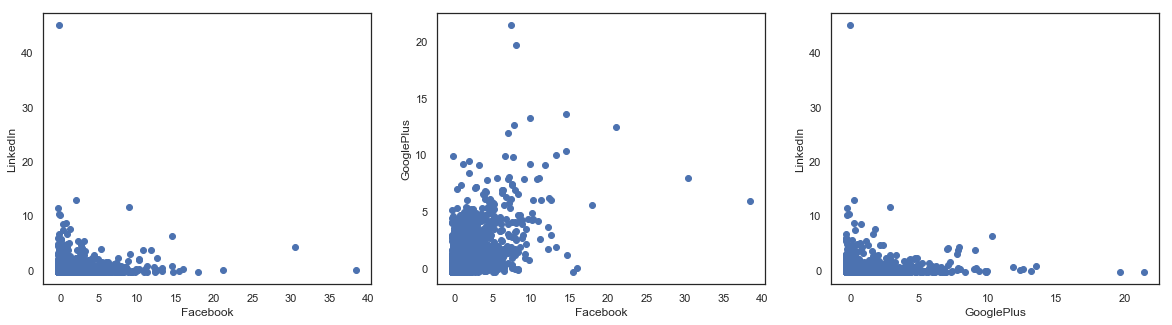

In [538]:
topics = ['obama', 'microsoft','economy', 'palestine']
topic = topics[0]

f_e_pop = news_df[news_df['Topic']==topic].Facebook_scaled
l_e_pop = news_df[news_df['Topic']==topic].LinkedIn_scaled
g_e_pop = news_df[news_df['Topic']==topic].GooglePlus_scaled

plt.figure(figsize = (20,5))

ax1 = plt.subplot(1,3,1)
ax1 = plt.scatter(f_e_pop, l_e_pop)
plt.xlabel('Facebook')
plt.ylabel('LinkedIn')

ax2 = plt.subplot(1,3,2)
ax2 = plt.scatter(f_e_pop, g_e_pop)
plt.xlabel('Facebook')
plt.ylabel('GooglePlus')

ax3 = plt.subplot(1,3,3)
ax3 = plt.scatter(g_e_pop,l_e_pop)
plt.xlabel('GooglePlus')
plt.ylabel('LinkedIn')

Text(0, 0.5, 'GooglePlus')

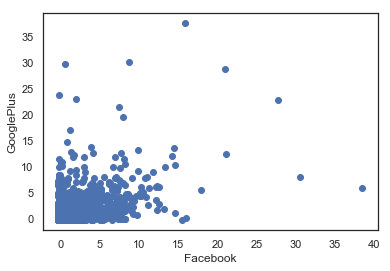

In [525]:
plt.scatter(f_pop, g_pop)
plt.xlabel('Facebook')
plt.ylabel('GooglePlus')

### Different Topics

In [521]:
topics = ['obama', 'microsoft','economy', 'palestine']
topic = topics[1]

f_e_pop = news_df[news_df['Topic']==topic].Facebook_scaled
l_e_pop = news_df[news_df['Topic']==topic].LinkedIn_scaled
g_e_pop = news_df[news_df['Topic']==topic].GooglePlus_scaled

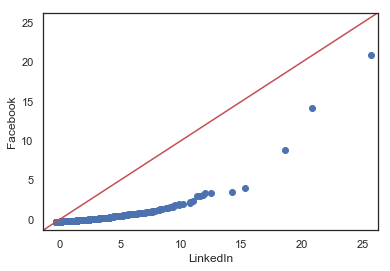

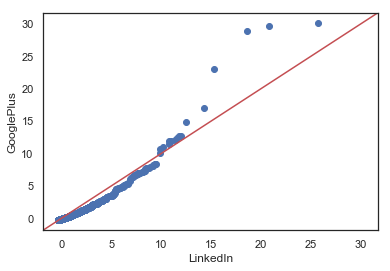

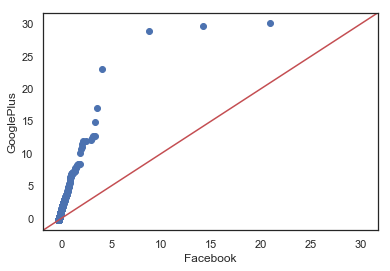

In [522]:
pp_f = sm.ProbPlot(f_e_pop, fit=False)
pp_l = sm.ProbPlot(l_e_pop, fit=False)
pp_g = sm.ProbPlot(g_e_pop, fit=False)

fig1 = pp_f.qqplot(other=pp_l, line='45')
plt.xlabel('LinkedIn')
plt.ylabel('Facebook')

fig2 = pp_g.qqplot(other=pp_l, line='45')
plt.xlabel('LinkedIn')
plt.ylabel('GooglePlus')

fig3 = pp_g.qqplot(other=pp_f, line='45')
plt.xlabel('Facebook')
plt.ylabel('GooglePlus');

In [486]:
obama_news = news_df[news_df['Topic']=='obama']

In [402]:
obama_news.corr()

,IDLink,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Title_len,num_platforms,diff_among_groups,Facebook_scaled,GooglePlus_scaled,LinkedIn_scaled,all_zero
IDLink,1.000000,0.010192,0.026348,-0.090157,-0.100104,0.023882,0.009895,NaN,-0.106604,-0.090157,-0.100104,0.023882,-0.000182
SentimentTitle,0.010192,1.000000,0.193300,-0.009552,-0.015315,0.008562,0.011494,NaN,-0.011885,-0.009552,-0.015315,0.008562,0.018258
SentimentHeadline,0.026348,0.193300,1.000000,-0.017029,-0.012199,0.006574,0.007208,NaN,-0.016813,-0.017029,-0.012199,0.006574,0.003537
Facebook,-0.090157,-0.009552,-0.017029,1.000000,0.601368,0.175585,0.035356,NaN,0.847081,1.000000,0.601368,0.175585,-0.106428
GooglePlus,-0.100104,-0.015315,-0.012199,0.601368,1.000000,0.161106,0.059692,NaN,0.780565,0.601368,1.000000,0.161106,-0.110673
LinkedIn,0.023882,0.008562,0.006574,0.175585,0.161106,1.000000,0.005003,NaN,0.424282,0.175585,0.161106,1.000000,-0.050085
Title_len,0.009895,0.011494,0.007208,0.035356,0.059692,0.005003,1.000000,NaN,0.050899,0.035356,0.059692,0.005003,-0.066479
num_platforms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diff_among_groups,-0.106604,-0.011885,-0.016813,0.847081,0.780565,0.424282,0.050899,NaN,1.000000,0.847081,0.780565,0.424282,-0.121095
Facebook_scaled,-0.090157,-0.009552,-0.017029,1.000000,0.601368,0.175585,0.035356,NaN,0.847081,1.000000,0.601368,0.175585,-0.106428


In [404]:
news_df[['diff_among_groups', 'SentimentTitle']][:5]

,diff_among_groups,SentimentTitle
736,0.002665,-0.055902
738,0.000245,-0.018326
742,0.000716,0.004360
746,0.007699,0.037689
747,0.001408,-0.166667
